## Importing necessary modules

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

## Loading the dataset

In [3]:

data = pd.read_csv('regularizer_lab_classification_dataset.csv')

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
data.columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15',
       'Feature_16', 'Feature_17', 'Feature_18', 'Feature_19', 'Feature_20',
       'Target'],
      dtype='object')

In [5]:
data.shape

(1000, 21)

In [6]:
data.dtypes

Feature_1     float64
Feature_2     float64
Feature_3     float64
Feature_4     float64
Feature_5     float64
Feature_6     float64
Feature_7     float64
Feature_8     float64
Feature_9     float64
Feature_10    float64
Feature_11    float64
Feature_12    float64
Feature_13    float64
Feature_14    float64
Feature_15    float64
Feature_16    float64
Feature_17    float64
Feature_18    float64
Feature_19    float64
Feature_20    float64
Target          int64
dtype: object

In [7]:
y

array([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

### Binary Classification Task

## Normalizing the dataset

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Defining the base neural network model

In [9]:
import torch.nn as nn

class BaseNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.layers(x)


## Defining the dropout neural network model

In [10]:

class DropoutNN(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(20, 64),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(32, 2)
        )
    def forward(self, x):
        return self.layers(x)


## Adding regularization variants

#### Base training function with no regularizers

In [11]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)


## Training function for L1 Regularizer

In [12]:

def train_epoch_l1(model, loader, criterion, optimizer, l1_lambda=0.001):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        base_loss = criterion(outputs, y_batch)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = base_loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

### Can pass weight decay in optimizer for L2

## Run the same model with 
### 1. No regularization
### 2. L1 regularization
### 3. L2 regularization
### 4. Dropout layers

### Compare and contrast results

In [16]:

import torch.optim as optim

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)


criterion = nn.CrossEntropyLoss()

num_epochs = 50
learning_rate = 0.0005

for reg_type in ['none', 'l1', 'l2', 'dropout']:
    if reg_type == 'dropout':
        model = DropoutNN(p=0.3)  # less aggressive dropout
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    else:
        model = BaseNN()
        if reg_type == 'l2':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
        else:
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        if reg_type == 'l1':
            train_loss = train_epoch_l1(model, train_loader, criterion, optimizer, l1_lambda=0.0005)
        else:
            train_loss = train_epoch(model, train_loader, criterion, optimizer)
        val_loss = validate(model, val_loader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    print(f"{reg_type.upper()} - Final Train Loss: {train_losses[-1]:.4f}, Final Val Loss: {val_losses[-1]:.4f}")

    results[reg_type] = {'train_loss': train_losses, 'val_loss': val_losses}


NONE - Final Train Loss: 0.0229, Final Val Loss: 0.1178
L1 - Final Train Loss: 0.1604, Final Val Loss: 0.1014
L2 - Final Train Loss: 0.0256, Final Val Loss: 0.1320
DROPOUT - Final Train Loss: 0.1169, Final Val Loss: 0.1136


## Plotting training and validation loss curves

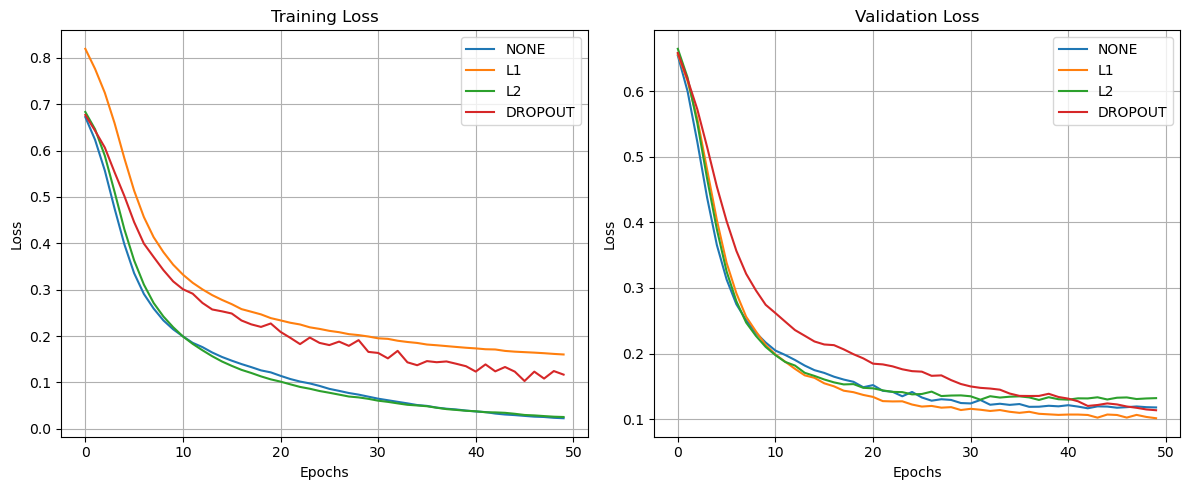

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for reg_type, losses in results.items():
    plt.plot(losses['train_loss'], label=f'{reg_type.upper()}')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for reg_type, losses in results.items():
    plt.plot(losses['val_loss'], label=f'{reg_type.upper()}')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
